## Setup

Using python 3.9.18

In [2]:
# install packages as needed
#! pip install sentence-transformers
#! pip install numpy
#! pip install pandas
#! pip install scikit-learn
#! pip install matplotlib
#! pip install numpy==1.24.1
#! pip install umap-learn

In [1]:
# libraries
import os
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import sklearn
from sklearn import cluster
from sklearn.cluster import KMeans

/opt/anaconda3/envs/myenv-python3-9/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
# load pre-trained sentence transformer model (aka SBERT)
model = SentenceTransformer('all-MiniLM-L6-v2')

/opt/anaconda3/envs/myenv-python3-9/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
# set working directory
# WORK
#%cd "/Users/tuo70125/My Drive/SANLab/Experiments/Conversation-Structure/"
# HOME
%cd "/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/"

/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure


# Embeddings

Get embeddings on transcript utterances, cluster labels, and participant topic labels.

In [4]:
# load all participant transcripts
all_pid_transcripts = pd.read_csv("./data/processed/all_participant_transcripts.csv")
# 523504 observations
# make all new_topic lowercase
all_pid_transcripts['new_topic'] = all_pid_transcripts['new_topic'].str.lower()


In [5]:
# load cluster labels (cluster number and HS-defined label)
cluster_labels = pd.read_csv("./data/output/topic_cluster_labels_50.csv")
# load topic + cluster match (topic label and cluster number)
cluster_50 = pd.read_csv("./data/output/topic_clusters_50.csv")
# merge on clusters (cluster number)
clusters_topics = pd.merge(cluster_50, cluster_labels, on = "clusters")

In [6]:
# add cluster_topics to all_pid_transcripts based on new_topic, PID, transcript_id match
df = pd.merge(all_pid_transcripts, clusters_topics, on = ['new_topic','PID','topic_order'], how="left")
# preview
df.head()

,turn_id,transcript_id,scaled_turn_id,speaker,utterance,PID,new_topic,topic_order,number_of_turns,embeddings,clusters,cluster_label
0,0,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.00,5ad7c075c25ea0000188486b,mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...,"[False, '66ea5116a642813c3dcf3c6f', None]",starting the call,0,1,[-7.38295913e-02 3.15889753e-02 -7.63121471e-...,0,starting the call
1,1,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.00,5de5538f8fde1c4dbc951498,"Hello, Can you hear me? I can, how are you doing?","[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,[-9.22262296e-02 1.34820297e-01 9.03446749e-...,19,greeting
2,2,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5ad7c075c25ea0000188486b,Good. How about you?,"[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,[-9.22262296e-02 1.34820297e-01 9.03446749e-...,19,greeting
3,3,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5de5538f8fde1c4dbc951498,"I am doing well, yeah,","[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,[-9.22262296e-02 1.34820297e-01 9.03446749e-...,19,greeting
4,4,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5ad7c075c25ea0000188486b,Sweet. So um I guess we could start off by tal...,"[False, '66ea5116a642813c3dcf3c6f', None]",introductions,2,12,[-5.39258495e-02 -2.13517584e-02 -3.90982293e-...,39,introduction


In [ ]:
# define embeddings functionß
def get_all_embeddings(text):
    return model.encode(text)ß

In [9]:
# get embeddings
df['embeddings_topic'] = df['new_topic'].apply(get_all_embeddings)
print("Done with topic embeddings!")

df['embeddings_utterance'] = df['utterance'].apply(get_all_embeddings)
print("Done with utterance embeddings!")

df['embeddings_cluster'] = df['cluster_label'].apply(get_all_embeddings)
print("Done with cluster embeddings!")

# preview
df.head()

Done with topic embeddings!
Done with utterance embeddings!
Done with cluster embeddings!


,turn_id,transcript_id,scaled_turn_id,speaker,utterance,PID,new_topic,topic_order,number_of_turns,embeddings,clusters,cluster_label,embeddings_topic,embeddings_utterance,embeddings_cluster
0,0,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.00,5ad7c075c25ea0000188486b,mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...,"[False, '66ea5116a642813c3dcf3c6f', None]",starting the call,0,1,[-7.38295913e-02 3.15889753e-02 -7.63121471e-...,0,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[0.060678475, 0.005255911, -0.0042183995, 0.02...","[-0.07382959, 0.031588975, -0.07631215, -0.006..."
1,1,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.00,5de5538f8fde1c4dbc951498,"Hello, Can you hear me? I can, how are you doing?","[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,[-9.22262296e-02 1.34820297e-01 9.03446749e-...,19,greeting,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...","[-0.020778073, -0.015140475, 0.013267419, -0.0...","[-0.09222623, 0.1348203, 0.090344675, 0.070808..."
2,2,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5ad7c075c25ea0000188486b,Good. How about you?,"[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,[-9.22262296e-02 1.34820297e-01 9.03446749e-...,19,greeting,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...","[0.039609965, -0.01397195, 0.03664549, 0.02249...","[-0.09222623, 0.1348203, 0.090344675, 0.070808..."
3,3,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5de5538f8fde1c4dbc951498,"I am doing well, yeah,","[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,[-9.22262296e-02 1.34820297e-01 9.03446749e-...,19,greeting,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...","[-0.023786038, -0.08440631, 0.10901276, 0.0035...","[-0.09222623, 0.1348203, 0.090344675, 0.070808..."
4,4,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5ad7c075c25ea0000188486b,Sweet. So um I guess we could start off by tal...,"[False, '66ea5116a642813c3dcf3c6f', None]",introductions,2,12,[-5.39258495e-02 -2.13517584e-02 -3.90982293e-...,39,introduction,"[-0.05392585, -0.021351758, -0.03909823, 0.054...","[0.013385294, -0.042186055, 0.023476379, 0.002...","[-0.04506645, 0.058423698, -0.023994604, 0.060..."


In [10]:
# calculate cosine similarity between sets of embeddings
df['topic_cluster_similarity'] = df.apply(lambda row: cosine_similarity([row['embeddings_cluster']], [row['embeddings_topic']])[0][0], axis = 1)
df['topic_utterance_similarity'] = df.apply(lambda row: cosine_similarity([row['embeddings_utterance']], [row['embeddings_topic']])[0][0], axis = 1)
df['cluster_utterance_similarity'] = df.apply(lambda row: cosine_similarity([row['embeddings_cluster']], [row['embeddings_utterance']])[0][0], axis = 1)
# preview
df.head()

,turn_id,transcript_id,scaled_turn_id,speaker,utterance,PID,new_topic,topic_order,number_of_turns,embeddings,clusters,cluster_label,embeddings_topic,embeddings_utterance,embeddings_cluster,topic_cluster_similarity,topic_utterance_similarity,cluster_utterance_similarity
0,0,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.00,5ad7c075c25ea0000188486b,mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...,"[False, '66ea5116a642813c3dcf3c6f', None]",starting the call,0,1,[-7.38295913e-02 3.15889753e-02 -7.63121471e-...,0,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[0.060678475, 0.005255911, -0.0042183995, 0.02...","[-0.07382959, 0.031588975, -0.07631215, -0.006...",1.000000,0.094303,0.094303
1,1,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.00,5de5538f8fde1c4dbc951498,"Hello, Can you hear me? I can, how are you doing?","[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,[-9.22262296e-02 1.34820297e-01 9.03446749e-...,19,greeting,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...","[-0.020778073, -0.015140475, 0.013267419, -0.0...","[-0.09222623, 0.1348203, 0.090344675, 0.070808...",1.000000,0.461409,0.461409
2,2,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5ad7c075c25ea0000188486b,Good. How about you?,"[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,[-9.22262296e-02 1.34820297e-01 9.03446749e-...,19,greeting,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...","[0.039609965, -0.01397195, 0.03664549, 0.02249...","[-0.09222623, 0.1348203, 0.090344675, 0.070808...",1.000000,0.272889,0.272889
3,3,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5de5538f8fde1c4dbc951498,"I am doing well, yeah,","[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,[-9.22262296e-02 1.34820297e-01 9.03446749e-...,19,greeting,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...","[-0.023786038, -0.08440631, 0.10901276, 0.0035...","[-0.09222623, 0.1348203, 0.090344675, 0.070808...",1.000000,0.291908,0.291908
4,4,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5ad7c075c25ea0000188486b,Sweet. So um I guess we could start off by tal...,"[False, '66ea5116a642813c3dcf3c6f', None]",introductions,2,12,[-5.39258495e-02 -2.13517584e-02 -3.90982293e-...,39,introduction,"[-0.05392585, -0.021351758, -0.03909823, 0.054...","[0.013385294, -0.042186055, 0.023476379, 0.002...","[-0.04506645, 0.058423698, -0.023994604, 0.060...",0.681177,0.314414,0.181884


In [11]:
# save
df.to_csv("./data/output/topic_cluster_utterance_similarity.csv", index = False)
df.to_pickle("./data/output/topic_cluster_utterance_similarity.pkl")

## TSNE

In [4]:
# load topic cluster utterance similarity if not already loaded
df = pd.read_pickle("./data/output/topic_cluster_utterance_similarity.pkl")

In [8]:
# drop the redundant embeddings variable
df_melt = df.drop('embeddings', axis = 1)
# using melt, pivot embeddings longer
df_melt = df_melt.melt(
    id_vars = ['turn_id', 'transcript_id', 'scaled_turn_id', 'speaker', 'utterance', 'PID',
               'new_topic', 'topic_order', 'number_of_turns', 'clusters', 'cluster_label',
               'topic_cluster_similarity', 'topic_utterance_similarity', 'cluster_utterance_similarity'],
    value_vars = ['embeddings_topic', 'embeddings_utterance', 'embeddings_cluster'],
    var_name = 'embedding_type',
    value_name = 'embeddings'
)
# preview
df_melt.head()

,turn_id,transcript_id,scaled_turn_id,speaker,utterance,PID,new_topic,topic_order,number_of_turns,clusters,cluster_label,topic_cluster_similarity,topic_utterance_similarity,cluster_utterance_similarity,embedding_type,embeddings
0,0,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.00,5ad7c075c25ea0000188486b,mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...,"[False, '66ea5116a642813c3dcf3c6f', None]",starting the call,0,1,0,starting the call,1.000000,0.094303,0.094303,embeddings_topic,"[-0.07382959, 0.031588975, -0.07631215, -0.006..."
1,1,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.00,5de5538f8fde1c4dbc951498,"Hello, Can you hear me? I can, how are you doing?","[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,19,greeting,1.000000,0.461409,0.461409,embeddings_topic,"[-0.09222623, 0.1348203, 0.090344675, 0.070808..."
2,2,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5ad7c075c25ea0000188486b,Good. How about you?,"[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,19,greeting,1.000000,0.272889,0.272889,embeddings_topic,"[-0.09222623, 0.1348203, 0.090344675, 0.070808..."
3,3,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5de5538f8fde1c4dbc951498,"I am doing well, yeah,","[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,19,greeting,1.000000,0.291908,0.291908,embeddings_topic,"[-0.09222623, 0.1348203, 0.090344675, 0.070808..."
4,4,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5ad7c075c25ea0000188486b,Sweet. So um I guess we could start off by tal...,"[False, '66ea5116a642813c3dcf3c6f', None]",introductions,2,12,39,introduction,0.681177,0.314414,0.181884,embeddings_topic,"[-0.05392585, -0.021351758, -0.03909823, 0.054..."


In [10]:
# initialize PCA with 50 components
pca = PCA(n_components=50)

# flatten embeddings into numpy arrays for PCA
pca_embeddings = np.array(df_melt['embeddings'].tolist())

# apply PCA to reduce embeddings to 50 dimensions
reduced_embeddings = pca.fit_transform(pca_embeddings)

# store reduced embeddings as a list in each row
df_melt['pca_embeddings'] = [list(embedding) for embedding in reduced_embeddings]

# show
df_melt.head()


,turn_id,transcript_id,scaled_turn_id,speaker,utterance,PID,new_topic,topic_order,number_of_turns,clusters,cluster_label,topic_cluster_similarity,topic_utterance_similarity,cluster_utterance_similarity,embedding_type,embeddings,pca_embeddings
0,0,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.00,5ad7c075c25ea0000188486b,mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...,"[False, '66ea5116a642813c3dcf3c6f', None]",starting the call,0,1,0,starting the call,1.000000,0.094303,0.094303,embeddings_topic,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[0.1547562, 0.14082071, -0.08391107, -0.190288..."
1,1,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.00,5de5538f8fde1c4dbc951498,"Hello, Can you hear me? I can, how are you doing?","[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,19,greeting,1.000000,0.461409,0.461409,embeddings_topic,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...","[0.040088624, 0.09938124, -0.17323293, 0.03725..."
2,2,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5ad7c075c25ea0000188486b,Good. How about you?,"[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,19,greeting,1.000000,0.272889,0.272889,embeddings_topic,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...","[0.037713487, 0.088402584, -0.17632043, 0.0089..."
3,3,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5de5538f8fde1c4dbc951498,"I am doing well, yeah,","[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,19,greeting,1.000000,0.291908,0.291908,embeddings_topic,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...","[0.038885694, 0.0509147, -0.19893673, 0.054010..."
4,4,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5ad7c075c25ea0000188486b,Sweet. So um I guess we could start off by tal...,"[False, '66ea5116a642813c3dcf3c6f', None]",introductions,2,12,39,introduction,0.681177,0.314414,0.181884,embeddings_topic,"[-0.05392585, -0.021351758, -0.03909823, 0.054...","[-0.07822974, -0.022360077, -0.030555015, 0.09..."


In [11]:
# initialize t-sne
tsne = TSNE(n_components=2, random_state=42)

# get tsne on the pca_embeddings
tsne_embeddings = np.stack(df_melt['pca_embeddings'].values)

# apply tsne and store results
tsne_results = tsne.fit_transform(tsne_embeddings)

# make into a data frame
tsne_results = pd.DataFrame(tsne_results, columns = ['tsne1','tsne2'])

# merge with df_melt
df_melt_tsne = pd.concat([df_melt, tsne_results], axis = 1)

# preview
df_melt_tsne.head()

,turn_id,transcript_id,scaled_turn_id,speaker,utterance,PID,new_topic,topic_order,number_of_turns,clusters,cluster_label,topic_cluster_similarity,topic_utterance_similarity,cluster_utterance_similarity,embedding_type,embeddings,pca_embeddings,tsne1,tsne2
0,0,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.00,5ad7c075c25ea0000188486b,mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...,"[False, '66ea5116a642813c3dcf3c6f', None]",starting the call,0,1,0,starting the call,1.000000,0.094303,0.094303,embeddings_topic,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[0.1547562, 0.14082071, -0.08391107, -0.190288...",4.398840,5.604674
1,1,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.00,5de5538f8fde1c4dbc951498,"Hello, Can you hear me? I can, how are you doing?","[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,19,greeting,1.000000,0.461409,0.461409,embeddings_topic,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...","[0.040088624, 0.09938124, -0.17323293, 0.03725...",-100.419083,136.053802
2,2,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5ad7c075c25ea0000188486b,Good. How about you?,"[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,19,greeting,1.000000,0.272889,0.272889,embeddings_topic,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...","[0.037713487, 0.088402584, -0.17632043, 0.0089...",11.766006,8.642733
3,3,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5de5538f8fde1c4dbc951498,"I am doing well, yeah,","[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,19,greeting,1.000000,0.291908,0.291908,embeddings_topic,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...","[0.038885694, 0.0509147, -0.19893673, 0.054010...",11.858953,8.765419
4,4,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5ad7c075c25ea0000188486b,Sweet. So um I guess we could start off by tal...,"[False, '66ea5116a642813c3dcf3c6f', None]",introductions,2,12,39,introduction,0.681177,0.314414,0.181884,embeddings_topic,"[-0.05392585, -0.021351758, -0.03909823, 0.054...","[-0.07822974, -0.022360077, -0.030555015, 0.09...",118.123085,-97.867882


In [12]:
# save
df_melt_tsne.to_csv("./data/output/topic_cluster_utterance_tsne.csv", index = False)
df_melt_tsne.to_pickle("./data/output/topic_cluster_utterance_tsne.pkl")

# -------------------

# FIX TSNE
1. figure out why some rows are being dropped (include all unique utterances, cluster labels, and topic label embeddings to transform them all into tsne space)
2. run tsne on embeddings and match with original utterances, cluster labels, topic labels (ensure tsne dimensinos match the type of text (i.e., embedding = utterance, tsne = utterance))

In [148]:
# FIX TSNE

# TSNE
### Run after Save Pickles to load .pkl files

Get TSNE from utterance embeddings, cluster label embeddings, and participant topic embeddings

In [130]:
# load pickle files
utterances = pd.read_pickle("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/utterance_embeddings.pkl")
cluster = pd.read_pickle("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/cluster_embeddings.pkl")
#topics = pd.read_pickle("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/participant_topic_label_embeddings.pkl")
topics = pd.read_pickle("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/topic_clusters_50.pkl")


In [126]:
# remove topic order from utterances
utterances = utterances.drop(columns=['topic_order'])
utterances.head()

,turn_id,scaled_turn_id,turn_length_s,transcript_id,PID,utterance,new_topic,embeddings_utterance
0,0,0.00,85.01,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]",mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...,starting the call,"[0.060678475, 0.005255911, -0.0042183995, 0.02..."
1,1,0.00,5.02,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]","Hello, Can you hear me? I can, how are you doing?",greeting,"[-0.020778073, -0.015140475, 0.013267419, -0.0..."
2,2,0.01,0.92,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]",Good. How about you?,greeting,"[0.039609965, -0.01397195, 0.03664549, 0.02249..."
3,3,0.01,2.30,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]","I am doing well, yeah,",greeting,"[-0.023786038, -0.08440631, 0.10901276, 0.0035..."
4,4,0.01,3.62,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]",Sweet. So um I guess we could start off by tal...,introductions,"[0.013385294, -0.042186055, 0.023476379, 0.002..."


In [131]:
cluster.head()

,clusters,cluster_label,embeddings_clusters
0,0,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006..."
1,1,covid,"[-0.027814034, 0.051265784, -0.043334875, 0.00..."
2,2,family,"[-0.09010316, 0.07598015, -0.017394636, 0.0018..."
3,3,"research, study","[0.012744962, 0.08843464, -0.034293596, 0.0650..."
4,4,"employment, job","[-0.050764263, 0.08114441, 0.016966721, 0.0311..."


In [132]:
topics.head()

,PID,new_topic,topic_order,number_of_turns,embeddings,clusters
0,"[False, '66ea5116a642813c3dcf3c6f', None]",starting the call,0,1,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",0
9977,"[False, '5e8b765e88065404c4d50fe2', None]",starting the call,0,1,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",0
33858,"[False, '60061a88cef0ed96c3a26e58', None]",starting the call,0,3,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",0
9965,"[False, '675cf786b9fb0e4f223877c1', None]",starting the call,0,14,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",0
2796,"[False, '6295b064f01df59a15157dfc', None]",starting the call,0,2,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",0


## Similarity Between Utterances, Labels, and Clusters

In [133]:
# merge utterances with topic labels
merged = pd.merge(utterances, topics, on=['PID','new_topic'])
merged.head()

,turn_id,scaled_turn_id,turn_length_s,transcript_id,PID,utterance,new_topic,topic_order_x,embeddings_utterance,topic_order_y,number_of_turns,embeddings,clusters
0,0,0.00,85.01,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]",mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...,starting the call,1,"[0.060678475, 0.005255911, -0.0042183995, 0.02...",0,1,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",0
1,1,0.00,5.02,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]","Hello, Can you hear me? I can, how are you doing?",greeting,2,"[-0.020778073, -0.015140475, 0.013267419, -0.0...",1,3,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",19
2,2,0.01,0.92,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]",Good. How about you?,greeting,2,"[0.039609965, -0.01397195, 0.03664549, 0.02249...",1,3,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",19
3,3,0.01,2.30,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]","I am doing well, yeah,",greeting,2,"[-0.023786038, -0.08440631, 0.10901276, 0.0035...",1,3,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",19
4,4,0.01,3.62,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]",Sweet. So um I guess we could start off by tal...,introductions,3,"[0.013385294, -0.042186055, 0.023476379, 0.002...",2,12,"[-0.05392585, -0.021351758, -0.03909823, 0.054...",39


In [134]:
# now merge with cluster labels
merged = pd.merge(merged, cluster, on='clusters')
merged.head()

,turn_id,scaled_turn_id,turn_length_s,transcript_id,PID,utterance,new_topic,topic_order_x,embeddings_utterance,topic_order_y,number_of_turns,embeddings,clusters,cluster_label,embeddings_clusters
0,0,0.00,85.01,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]",mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...,starting the call,1,"[0.060678475, 0.005255911, -0.0042183995, 0.02...",0,1,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",0,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006..."
1,1,0.00,5.02,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]","Hello, Can you hear me? I can, how are you doing?",greeting,2,"[-0.020778073, -0.015140475, 0.013267419, -0.0...",1,3,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",19,greeting,"[-0.09222623, 0.1348203, 0.090344675, 0.070808..."
2,2,0.01,0.92,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]",Good. How about you?,greeting,2,"[0.039609965, -0.01397195, 0.03664549, 0.02249...",1,3,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",19,greeting,"[-0.09222623, 0.1348203, 0.090344675, 0.070808..."
3,3,0.01,2.30,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]","I am doing well, yeah,",greeting,2,"[-0.023786038, -0.08440631, 0.10901276, 0.0035...",1,3,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",19,greeting,"[-0.09222623, 0.1348203, 0.090344675, 0.070808..."
4,4,0.01,3.62,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]",Sweet. So um I guess we could start off by tal...,introductions,3,"[0.013385294, -0.042186055, 0.023476379, 0.002...",2,12,"[-0.05392585, -0.021351758, -0.03909823, 0.054...",39,introduction,"[-0.04506645, 0.058423698, -0.023994604, 0.060..."


In [135]:
# calculate cosine similarity between sets of embeddings
merged['topic_cluster_similarity'] = merged.apply(lambda row: cosine_similarity([row['embeddings_clusters']], [row['embeddings']])[0][0], axis=1)
merged['topic_utterance_similarity'] = merged.apply(lambda row: cosine_similarity([row['embeddings']], [row['embeddings_utterance']])[0][0], axis=1)
merged['cluster_utterance_similarity'] = merged.apply(lambda row: cosine_similarity([row['embeddings_clusters']], [row['embeddings_utterance']])[0][0], axis=1)
merged.head()

,turn_id,scaled_turn_id,turn_length_s,transcript_id,PID,utterance,new_topic,topic_order_x,embeddings_utterance,topic_order_y,number_of_turns,embeddings,clusters,cluster_label,embeddings_clusters,topic_cluster_similarity,topic_utterance_similarity,cluster_utterance_similarity
0,0,0.00,85.01,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]",mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...,starting the call,1,"[0.060678475, 0.005255911, -0.0042183995, 0.02...",0,1,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",0,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",1.000000,0.094303,0.094303
1,1,0.00,5.02,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]","Hello, Can you hear me? I can, how are you doing?",greeting,2,"[-0.020778073, -0.015140475, 0.013267419, -0.0...",1,3,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",19,greeting,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",1.000000,0.461409,0.461409
2,2,0.01,0.92,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]",Good. How about you?,greeting,2,"[0.039609965, -0.01397195, 0.03664549, 0.02249...",1,3,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",19,greeting,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",1.000000,0.272889,0.272889
3,3,0.01,2.30,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]","I am doing well, yeah,",greeting,2,"[-0.023786038, -0.08440631, 0.10901276, 0.0035...",1,3,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",19,greeting,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",1.000000,0.291908,0.291908
4,4,0.01,3.62,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]",Sweet. So um I guess we could start off by tal...,introductions,3,"[0.013385294, -0.042186055, 0.023476379, 0.002...",2,12,"[-0.05392585, -0.021351758, -0.03909823, 0.054...",39,introduction,"[-0.04506645, 0.058423698, -0.023994604, 0.060...",0.681177,0.314414,0.181884


In [136]:
# save
merged.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/embedding_similarity.csv", index=False)

In [137]:
merged.to_pickle("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/embedding_similarity.pkl")

## UMAP on all embeddings

In [142]:
import umap.umap_ as umap
# create UMAP model to reduce dimensionality
umap_model = umap.UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.1,
                       metric='cosine', random_state = 100)

In [143]:
# format data

# only select each embedding type
merged_cluster = merged[['PID','new_topic','cluster_label','utterance','embeddings_clusters']]
merged_topic = merged[['PID','new_topic','cluster_label','utterance','embeddings']]
merged_utterance = merged[['PID','new_topic','cluster_label','utterance','embeddings_utterance']]

# add type column and re-name to match embeddings variable name in merged_50_topic
merged_cluster['type'] = 'cluster'
merged_cluster = merged_cluster.rename(columns = {'embeddings_clusters':'embeddings'})

merged_topic['type'] = 'topic'

merged_utterance['type'] = 'utterance'
merged_utterance = merged_utterance.rename(columns = {'embeddings_utterance':'embeddings'})

# combine back together
merged_umap = pd.concat([merged_cluster,merged_topic,merged_utterance], ignore_index=True)

# preview
merged_umap.head()


/var/folders/vj/qkpl_dxs7fd3f2nl6_9794n00000gn/T/ipykernel_72226/199750130.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_cluster['type'] = 'cluster'
/var/folders/vj/qkpl_dxs7fd3f2nl6_9794n00000gn/T/ipykernel_72226/199750130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_topic['type'] = 'topic'
/var/folders/vj/qkpl_dxs7fd3f2nl6_9794n00000gn/T/ipykernel_72226/199750130.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

,PID,new_topic,cluster_label,utterance,embeddings,type
0,"[False, '66ea5116a642813c3dcf3c6f', None]",starting the call,starting the call,mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",cluster
1,"[False, '66ea5116a642813c3dcf3c6f', None]",greeting,greeting,"Hello, Can you hear me? I can, how are you doing?","[-0.09222623, 0.1348203, 0.090344675, 0.070808...",cluster
2,"[False, '66ea5116a642813c3dcf3c6f', None]",greeting,greeting,Good. How about you?,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",cluster
3,"[False, '66ea5116a642813c3dcf3c6f', None]",greeting,greeting,"I am doing well, yeah,","[-0.09222623, 0.1348203, 0.090344675, 0.070808...",cluster
4,"[False, '66ea5116a642813c3dcf3c6f', None]",introductions,introduction,Sweet. So um I guess we could start off by tal...,"[-0.04506645, 0.058423698, -0.023994604, 0.060...",cluster


In [144]:
# extract just embeddings
umap_embeddings = np.stack(merged_umap['embeddings'].values)

In [145]:
# fit UMAP and transform embeddings
umap_results = umap_model.fit_transform(umap_embeddings)
# convert to data frame
umap_df = pd.DataFrame(umap_results, columns = ['umap1','umap2'])

/opt/anaconda3/envs/myenv-python3-9/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/envs/myenv-python3-9/lib/python3.9/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/anaconda3/envs/myenv-python3-9/lib/python3.9/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/anaconda3/envs/myenv-python3-9/lib/python3.9/site-packages/umap/spectral.py:548: UserWarning: Sp

In [147]:
# merge umap results with stacked data frame
merged_umap_concat = pd.concat([merged_umap, umap_df], axis = 1)
# save
merged_umap_concat.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/umap_concat.csv", index=False)

In [146]:
# merge umap results with original merged data frame
merged_umap_final = pd.concat([merged, umap_df], axis=1)
# save
merged_umap_final.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/umap.csv", index=False)
# preview
merged_umap_final.head() 

,turn_id,scaled_turn_id,turn_length_s,transcript_id,PID,utterance,new_topic,topic_order_x,embeddings_utterance,topic_order_y,number_of_turns,embeddings,clusters,cluster_label,embeddings_clusters,topic_cluster_similarity,topic_utterance_similarity,cluster_utterance_similarity,umap1,umap2
0,0.0,0.00,85.01,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]",mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...,starting the call,1.0,"[0.060678475, 0.005255911, -0.0042183995, 0.02...",0.0,1.0,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",0.0,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",1.000000,0.094303,0.094303,12.191831,-14.294740
1,1.0,0.00,5.02,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]","Hello, Can you hear me? I can, how are you doing?",greeting,2.0,"[-0.020778073, -0.015140475, 0.013267419, -0.0...",1.0,3.0,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",19.0,greeting,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",1.000000,0.461409,0.461409,11.832419,-17.851759
2,2.0,0.01,0.92,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]",Good. How about you?,greeting,2.0,"[0.039609965, -0.01397195, 0.03664549, 0.02249...",1.0,3.0,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",19.0,greeting,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",1.000000,0.272889,0.272889,11.839114,-17.854891
3,3.0,0.01,2.30,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]","I am doing well, yeah,",greeting,2.0,"[-0.023786038, -0.08440631, 0.10901276, 0.0035...",1.0,3.0,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",19.0,greeting,"[-0.09222623, 0.1348203, 0.090344675, 0.070808...",1.000000,0.291908,0.291908,11.837659,-17.856243
4,4.0,0.01,3.62,01849238-f5f0-487e-bca4-7b4fe0c9625c,"[False, '66ea5116a642813c3dcf3c6f', None]",Sweet. So um I guess we could start off by tal...,introductions,3.0,"[0.013385294, -0.042186055, 0.023476379, 0.002...",2.0,12.0,"[-0.05392585, -0.021351758, -0.03909823, 0.054...",39.0,introduction,"[-0.04506645, 0.058423698, -0.023994604, 0.060...",0.681177,0.314414,0.181884,-13.485023,-10.794079


# Save Pickles

In [116]:
# get embeddings on topic labels
def get_topic_embeddings(row):
    # extract current topic from the row
    current = row['new_topic']
    # apply s-bert model to each string to get embeddings
    embeddings = model.encode(current)
    return embeddings

# get embeddings on the cluster labels
def get_cluster_embeddings(row):
    # extract current label from the row
    current = row['cluster_label']
    # apply s-bert model to each string to get embeddings
    embeddings = model.encode(current)
    return embeddings

# get embeddings on utterances
def get_utterance_embeddings(row):
    # extract current label from the row
    current = row['utterance']
    # apply s-bert model to each string to get embeddings
    embeddings = model.encode(current)
    return embeddings

## Utterance Embeddings

In [115]:
# load dense subset data with utterances
utterances = pd.read_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/processed/all_participant_transcripts.csv")
# lowercase all topics
utterances['new_topic'] = utterances['new_topic'].str.lower()
# preview
utterances.head()

,turn_id,transcript_id,scaled_turn_id,speaker,utterance,PID,new_topic,topic_order
0,0,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.00,5ad7c075c25ea0000188486b,mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...,"[False, '66ea5116a642813c3dcf3c6f', None]",starting the call,0
1,1,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.00,5de5538f8fde1c4dbc951498,"Hello, Can you hear me? I can, how are you doing?","[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1
2,2,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5ad7c075c25ea0000188486b,Good. How about you?,"[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1
3,3,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5de5538f8fde1c4dbc951498,"I am doing well, yeah,","[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1
4,4,01849238-f5f0-487e-bca4-7b4fe0c9625c,0.01,5ad7c075c25ea0000188486b,Sweet. So um I guess we could start off by tal...,"[False, '66ea5116a642813c3dcf3c6f', None]",introductions,2


In [ ]:
# get embeddings on utterances
utterances['embeddings_utterance'] = utterances.apply(get_utterance_embeddings, axis = 1)
# save
utterances.to_pickle("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/utterance_embeddings.pkl")
# show
utterances.head()

## Topic Labels

### Get Embeddings

In [117]:
# load topic label data to run kmeans clustering and identify clustered labels
cluster = pd.read_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/processed/all_participant_topic_labels.csv")

# lowercase all topics
cluster['new_topic'] = cluster['new_topic'].str.lower()

# save embeddings
cluster['topic_embeddings'] = cluster.apply(get_topic_embeddings, axis = 1)

# save embeddings as pickle
cluster.to_pickle("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/participant_topic_label_embeddings.pkl")

# preview
cluster.head()

,PID,new_topic,topic_order,number_of_turns,topic_embeddings
0,"[False, '66ea5116a642813c3dcf3c6f', None]",starting the call,0,1,"[-0.07382959, 0.031588975, -0.07631215, -0.006..."
1,"[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,"[-0.09222623, 0.1348203, 0.090344675, 0.070808..."
2,"[False, '66ea5116a642813c3dcf3c6f', None]",introductions,2,12,"[-0.05392585, -0.021351758, -0.03909823, 0.054..."
3,"[False, '66ea5116a642813c3dcf3c6f', None]",flying,3,25,"[0.057700507, 0.03469498, -0.028418075, 0.0820..."
4,"[False, '66ea5116a642813c3dcf3c6f', None]",schooling,4,2,"[0.022620993, 0.08201187, 0.026254188, 0.10571..."


### K-Means (50 Clusters)

In [ ]:
## 50 CLUSTERS ##

# kmeans on the new topic strings
# random_state ensures reproducible results

# create new cluster data frames for 50 topics
cluster_50 = pd.read_pickle("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/participant_topic_label_embeddings.pkl")
topic_array_50 = np.array([np.array(x) for x in cluster_50['topic_embeddings'].to_numpy()])
kmeans_topics_50 = sklearn.cluster.KMeans(n_clusters=50, random_state=100).fit(topic_array_50)
kmeans_labels_50 = kmeans_topics_50.predict(topic_array_50)
# bind labels back to cluster_50 and group based on what's being clustered together
cluster_50['clusters'] = kmeans_labels_50

# sort by cluster number
cluster_50 = cluster_50.sort_values(by = ['clusters'])

# save
cluster_50.to_pickle("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/topic_clusters_50.pkl")
cluster_50.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/topic_clusters_50.csv", index = False)

# show
cluster_50.head()

## Cluster Labels

In [118]:
# load cluster labels for 50 clusters from kmeans
cluster_labels_50 = pd.read_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/topic_cluster_labels_50.csv")

# get embeddings on cluster labels
cluster_labels_50['embeddings_clusters'] = cluster_labels_50.apply(get_cluster_embeddings, axis = 1)

# save
cluster_labels_50.to_pickle("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/cluster_embeddings.pkl")

# show
cluster_labels_50.head()

,clusters,cluster_label,embeddings_clusters
0,0,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006..."
1,1,covid,"[-0.027814034, 0.051265784, -0.043334875, 0.00..."
2,2,family,"[-0.09010316, 0.07598015, -0.017394636, 0.0018..."
3,3,"research, study","[0.012744962, 0.08843464, -0.034293596, 0.0650..."
4,4,"employment, job","[-0.050764263, 0.08114441, 0.016966721, 0.0311..."


## TSNE

In [5]:
# using same backbiter data (df) from tile section...
# 1: get s-bert word embeddings per utterance 
# 2: reduce embedding dimensionality for each utterance to plot
df.head()

,turn_id,speaker,transcript_id,utterance
0,0,5ad7c075c25ea0000188486b,01849238-f5f0-487e-bca4-7b4fe0c9625c,mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...
1,1,5de5538f8fde1c4dbc951498,01849238-f5f0-487e-bca4-7b4fe0c9625c,"Hello, Can you hear me? I can, how are you doing?"
2,2,5ad7c075c25ea0000188486b,01849238-f5f0-487e-bca4-7b4fe0c9625c,Good. How about you?
3,3,5de5538f8fde1c4dbc951498,01849238-f5f0-487e-bca4-7b4fe0c9625c,"I am doing well, yeah,"
4,4,5ad7c075c25ea0000188486b,01849238-f5f0-487e-bca4-7b4fe0c9625c,Sweet. So um I guess we could start off by tal...


In [27]:
# get sbert embeddings for each utterance
def get_embeddings(row):
    # extract current utterance from the row
    current = row['utterance']
    # apply s-bert model to each utterance to get embeddings
    embeddings = model.encode(current)
    return embeddings

# save embeddings 
#df['utterance_embedding'] = df.apply(get_embeddings, axis = 1)

# preview 
#df.head()

In [8]:
# make the utterance embeddings into a 2D numpy array (one row per utterance)
tsne_embeddings = np.stack(df['utterance_embedding'].values)
# initialize t-sne
tsne = TSNE(n_components=2, random_state=42)
# apply t-sne
tsne_results = tsne.fit_transform(tsne_embeddings)
# convert results to a data frame
tsne_df = pd.DataFrame(tsne_results, columns=['tsne_1','tsne_2'])

# preview
tsne_df.head()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,tsne_1,tsne_2
0,-32.811100,80.783218
1,-29.132412,64.755722
2,30.533899,8.104946
3,14.504663,11.569782
4,-15.809656,20.190828


In [9]:
# merge tsne results with original data frame
df_tsne = pd.concat([df, tsne_df], axis=1)
# preview
df_tsne.head()

,turn_id,speaker,transcript_id,utterance,utterance_embedding,tsne_1,tsne_2
0,0,5ad7c075c25ea0000188486b,01849238-f5f0-487e-bca4-7b4fe0c9625c,mm. Mhm. Okay. Okay. Mm hmm. Mhm. Oh. Mhm. Oka...,"[0.060678475, 0.005255911, -0.0042183995, 0.02...",-32.811100,80.783218
1,1,5de5538f8fde1c4dbc951498,01849238-f5f0-487e-bca4-7b4fe0c9625c,"Hello, Can you hear me? I can, how are you doing?","[-0.020778073, -0.015140475, 0.013267419, -0.0...",-29.132412,64.755722
2,2,5ad7c075c25ea0000188486b,01849238-f5f0-487e-bca4-7b4fe0c9625c,Good. How about you?,"[0.039609965, -0.01397195, 0.03664549, 0.02249...",30.533899,8.104946
3,3,5de5538f8fde1c4dbc951498,01849238-f5f0-487e-bca4-7b4fe0c9625c,"I am doing well, yeah,","[-0.023786038, -0.08440631, 0.10901276, 0.0035...",14.504663,11.569782
4,4,5ad7c075c25ea0000188486b,01849238-f5f0-487e-bca4-7b4fe0c9625c,Sweet. So um I guess we could start off by tal...,"[0.013385294, -0.042186055, 0.023476379, 0.002...",-15.809656,20.190828


In [10]:
# save tsne data frame
df_tsne.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/annotated_transcripts_tsne.csv", index = False)

## Elbow test

Figure out the optimal number of clusters given the participant-provided topic labels.

In [21]:
# define data to fit
X = np.array([np.array(x) for x in cluster['embeddings'].to_numpy()])
#X = cluster['embeddings'].to_numpy()
# define range of possible k values to test
k_range = range(1,200)
# create a list to store inertia values for each k
inertia_values = []
# fit a kmeans model for each k and compute inertia
for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 100) # define random state to ensure same results every time
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

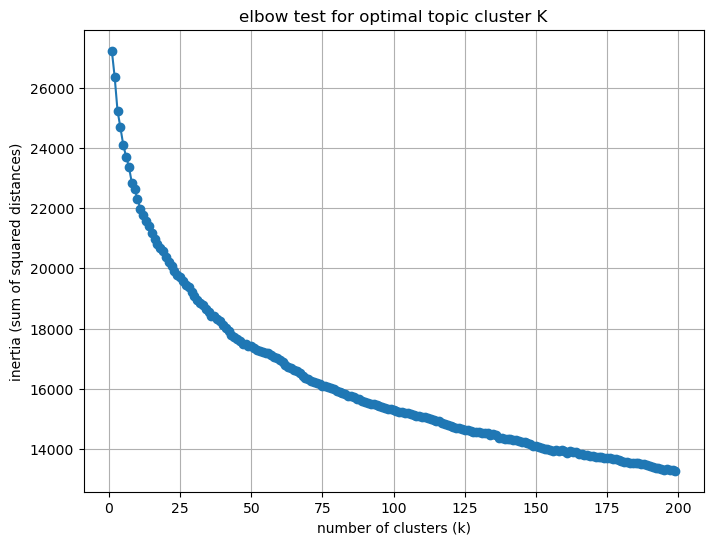

In [22]:
# now plot inertia as a function of cluster value
plt.figure(figsize = (12,10))
plt.plot(k_range, inertia_values, marker = 'o')
plt.title('elbow test for optimal topic cluster K')
plt.xlabel('number of clusters (k)')
plt.ylabel('inertia (sum of squared distances)')
plt.grid(True)
plt.show()

### Analysis

In [97]:
# load cluster label embeddings if not already loaded
#cluster = pd.read_pickle("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/participant_topic_label_embeddings.pkl")
# preview
cluster.head()

,PID,new_topic,topic_order,number_of_turns,embeddings
0,"[False, '66ea5116a642813c3dcf3c6f', None]",starting the call,0,1,"[-0.07382959, 0.031588975, -0.07631215, -0.006..."
1,"[False, '66ea5116a642813c3dcf3c6f', None]",greeting,1,3,"[-0.09222623, 0.1348203, 0.090344675, 0.070808..."
2,"[False, '66ea5116a642813c3dcf3c6f', None]",introductions,2,12,"[-0.05392585, -0.021351758, -0.03909823, 0.054..."
3,"[False, '66ea5116a642813c3dcf3c6f', None]",flying,3,25,"[0.057700507, 0.03469498, -0.028418075, 0.0820..."
4,"[False, '66ea5116a642813c3dcf3c6f', None]",schooling,4,2,"[0.022620993, 0.08201187, 0.026254188, 0.10571..."


,PID,new_topic,topic_order,number_of_turns,embeddings,clusters
0,"[False, '66ea5116a642813c3dcf3c6f', None]",starting the call,0,1,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",0
9977,"[False, '5e8b765e88065404c4d50fe2', None]",starting the call,0,1,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",0
33858,"[False, '60061a88cef0ed96c3a26e58', None]",starting the call,0,3,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",0
9965,"[False, '675cf786b9fb0e4f223877c1', None]",starting the call,0,14,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",0
2796,"[False, '6295b064f01df59a15157dfc', None]",starting the call,0,2,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",0


,clusters,cluster_label,embeddings_clusters
0,0,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006..."
1,1,covid,"[-0.027814034, 0.051265784, -0.043334875, 0.00..."
2,2,family,"[-0.09010316, 0.07598015, -0.017394636, 0.0018..."
3,3,"research, study","[0.012744962, 0.08843464, -0.034293596, 0.0650..."
4,4,"employment, job","[-0.050764263, 0.08114441, 0.016966721, 0.0311..."


,clusters,cluster_label,embeddings_clusters,PID,new_topic,topic_order,number_of_turns,embeddings
0,0,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[False, '66ea5116a642813c3dcf3c6f', None]",starting the call,0,1,"[-0.07382959, 0.031588975, -0.07631215, -0.006..."
1,0,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[False, '5e8b765e88065404c4d50fe2', None]",starting the call,0,1,"[-0.07382959, 0.031588975, -0.07631215, -0.006..."
2,0,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[False, '60061a88cef0ed96c3a26e58', None]",starting the call,0,3,"[-0.07382959, 0.031588975, -0.07631215, -0.006..."
3,0,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[False, '675cf786b9fb0e4f223877c1', None]",starting the call,0,14,"[-0.07382959, 0.031588975, -0.07631215, -0.006..."
4,0,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[False, '6295b064f01df59a15157dfc', None]",starting the call,0,2,"[-0.07382959, 0.031588975, -0.07631215, -0.006..."


In [ ]:

# sort by PID, transcript ID, and scaled_turn_id
#merged_50 = merged_50.sort_values(['PID','transcript_id','scaled_turn_id'],ascending=True)
# show
merged_50.head()

,clusters,cluster_label,embeddings_clusters,PID,new_topic,topic_order,number_of_turns,embeddings,turn_id,scaled_turn_id,turn_length_s,transcript_id,utterance,embeddings_utterance
0,NaN,NaN,NaN,"[False, '542498adfdf99b691fb384d1', None]",attendance,18,NaN,NaN,163.0,0.57,34.91,588c5b4b-5e92-426c-8acc-686628a7342f,you don't have to deal with them. I had the on...,"[0.027398381, 0.028032003, 0.090005144, -0.069..."
1,NaN,NaN,NaN,"[False, '542498adfdf99b691fb384d1', None]",attendance,18,NaN,NaN,164.0,0.57,8.92,588c5b4b-5e92-426c-8acc-686628a7342f,I wouldn't blame you have to wait like 15 minu...,"[0.037032455, -0.025818447, 0.08089819, -0.006..."
2,NaN,NaN,NaN,"[False, '542498adfdf99b691fb384d1', None]",attendance,18,NaN,NaN,166.0,0.58,0.32,588c5b4b-5e92-426c-8acc-686628a7342f,that's,"[0.029759444, -0.030165687, -0.0061162305, -0...."
3,NaN,NaN,NaN,"[False, '542498adfdf99b691fb384d1', None]",attendance,18,NaN,NaN,167.0,0.58,0.31,588c5b4b-5e92-426c-8acc-686628a7342f,bit.,"[0.049876336, 0.045652773, -0.029054847, -0.04..."
4,NaN,NaN,NaN,"[False, '542498adfdf99b691fb384d1', None]",attendance,18,NaN,NaN,169.0,0.59,10.11,588c5b4b-5e92-426c-8acc-686628a7342f,A lot of people who take those early class is ...,"[0.058266476, 0.017980408, 0.04888583, 0.03517..."


In [80]:
# save
merged_50.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/topic_cluster_similarity.csv", index = False)
merged_50.to_pickle("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/topic_cluster_similarity.pkl")

/var/folders/vj/qkpl_dxs7fd3f2nl6_9794n00000gn/T/ipykernel_72226/2213982571.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_50_cluster['type'] = 'cluster'
/var/folders/vj/qkpl_dxs7fd3f2nl6_9794n00000gn/T/ipykernel_72226/2213982571.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_50_topic['type'] = 'topic'
/var/folders/vj/qkpl_dxs7fd3f2nl6_9794n00000gn/T/ipykernel_72226/2213982571.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

,new_topic,cluster_label,utterance,embeddings,type
0,attendance,"entertainment, activities",you don't have to deal with them. I had the on...,"[0.06650323, -0.0014044356, 0.036373634, -0.02...",cluster
1,attendance,"entertainment, activities",I wouldn't blame you have to wait like 15 minu...,"[0.06650323, -0.0014044356, 0.036373634, -0.02...",cluster
2,attendance,"entertainment, activities",that's,"[0.06650323, -0.0014044356, 0.036373634, -0.02...",cluster
3,attendance,"entertainment, activities",bit.,"[0.06650323, -0.0014044356, 0.036373634, -0.02...",cluster
4,attendance,"entertainment, activities",A lot of people who take those early class is ...,"[0.06650323, -0.0014044356, 0.036373634, -0.02...",cluster


In [91]:
# initialize t-sne
my_tsne = TSNE(n_components=2, random_state=42)

In [92]:
# extract just embeddings
tsne_embeddings = np.stack(merged_50_tsne['embeddings'].values)

In [83]:
# apply tsne to reduce embeddings to 2D space
tsne_results = my_tsne.fit_transform(tsne_embeddings)
tsne_df = pd.DataFrame(tsne_results, columns = ['tsne1','tsne2'])
tsne_df = pd.concat([merged_50_tsne, tsne_df], axis = 1)

# save
tsne_df.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/tsne_topic_cluster_utterance.csv", index=False)

# show
tsne_df.head()

KeyboardInterrupt: 

In [85]:
tsne_df.head()

NameError: name 'tsne_df' is not defined

In [84]:
# save as pickle
tsne_df.to_pickle("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/tsne_topic_cluster_utterance.pkl")

NameError: name 'tsne_df' is not defined

### Elbow and other cluster numbers 

In [48]:
# define data to fit
X = np.array([np.array(x) for x in cluster['embeddings'].to_numpy()])
# define range of possible k values to test
k_range = range(1,100)
# create a list to store inertia values for each k
inertia_values = []
# fit a kmeans model for each k and compute inertia
for k in k_range:
    kmeans = KMeans(n_clusters = k, random_state = 100) # define random state to ensure same results every time
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

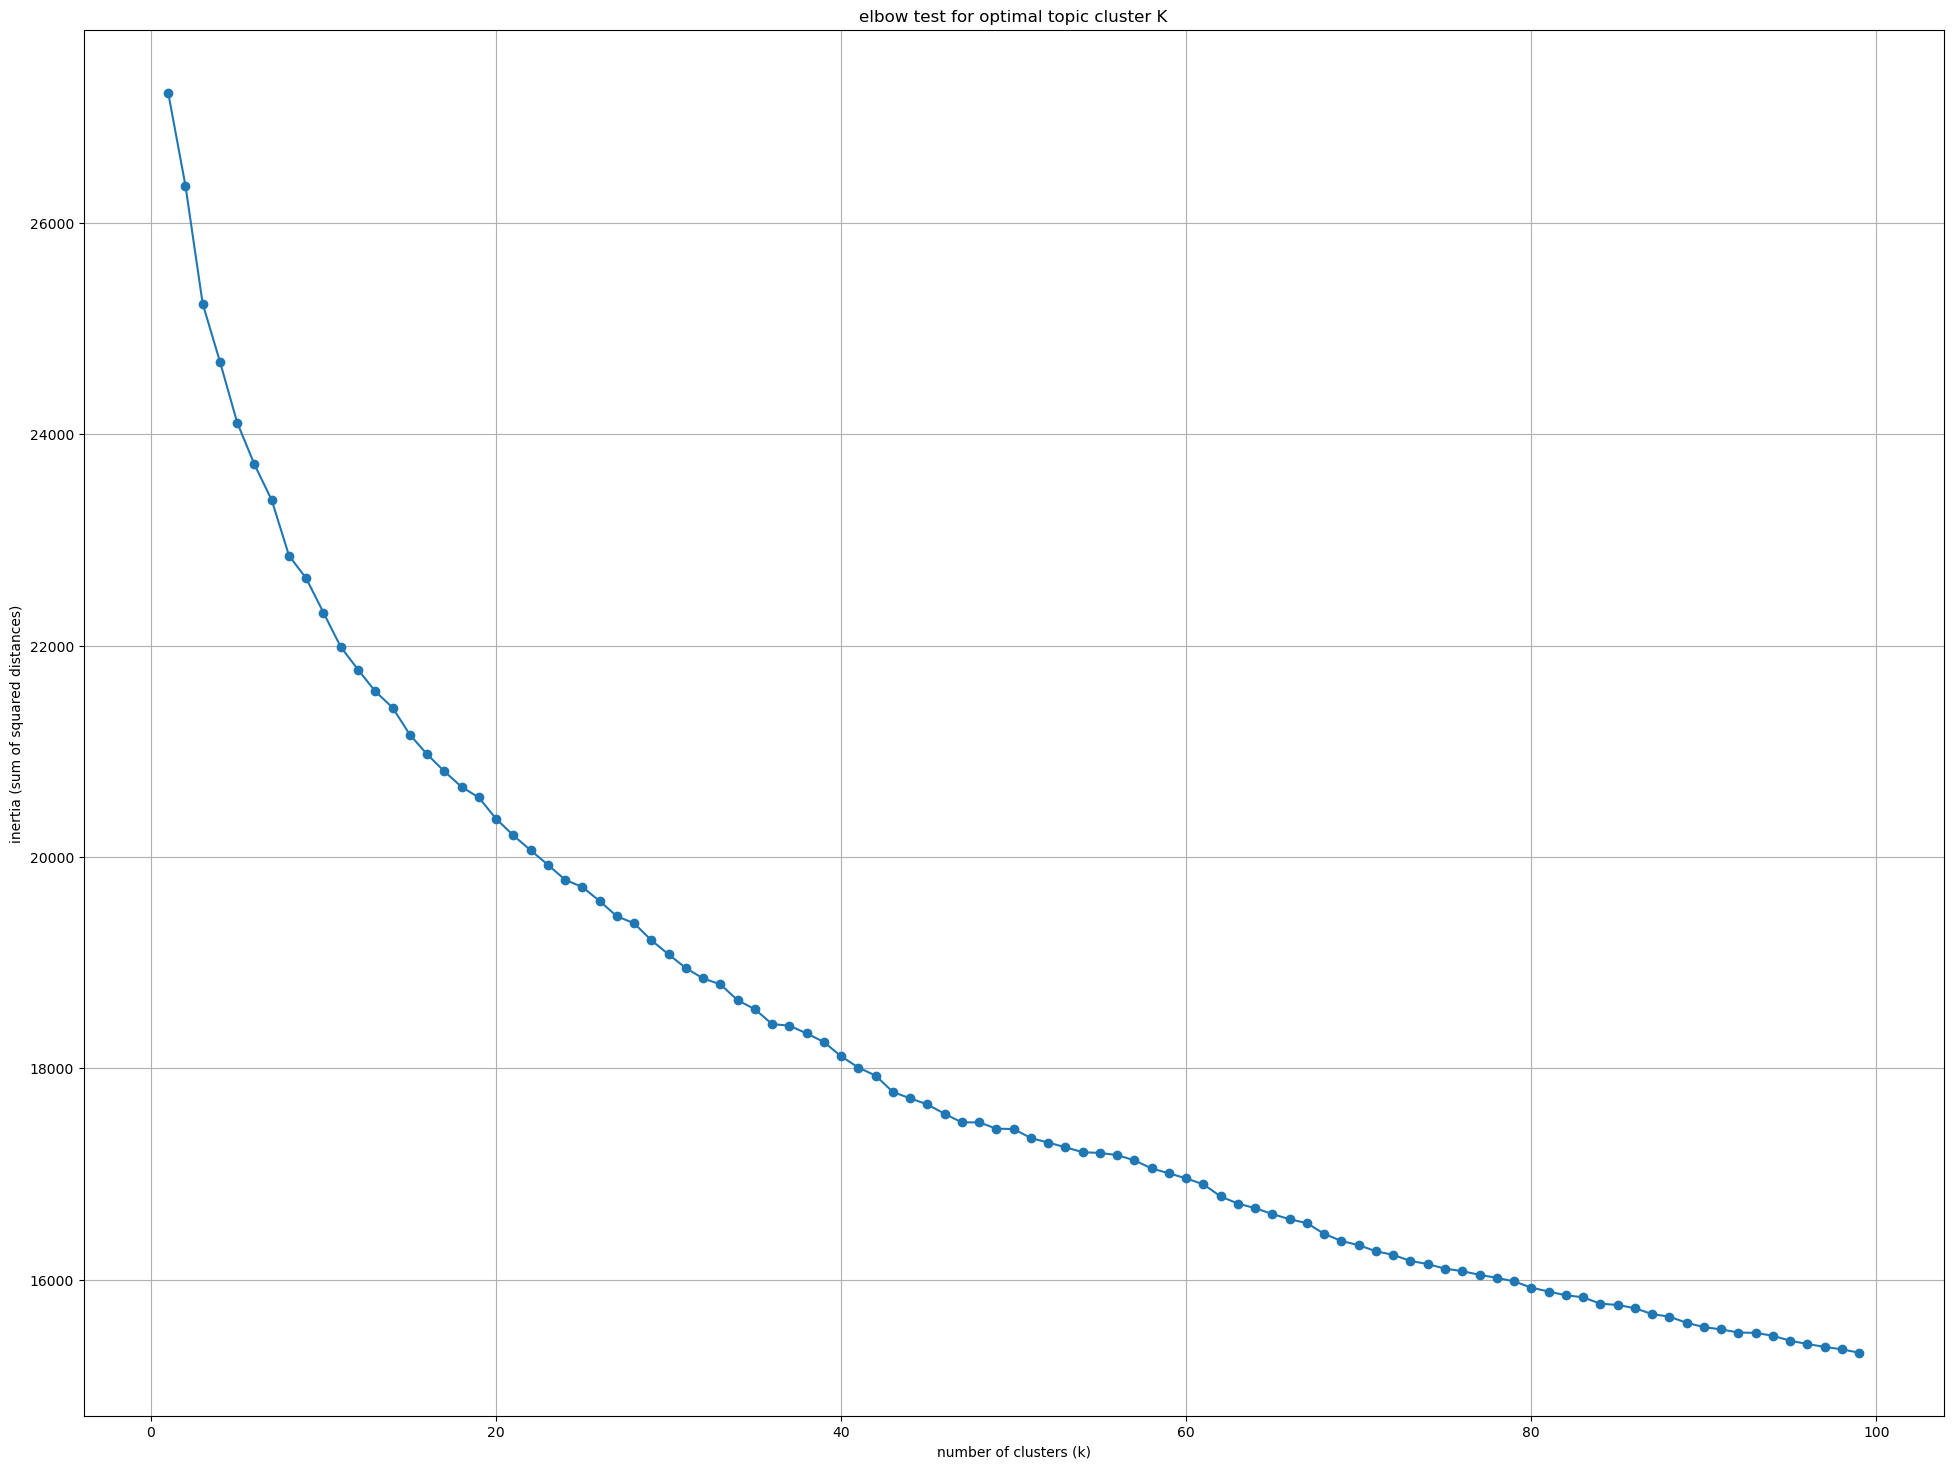

In [49]:
# now plot inertia as a function of cluster value
plt.figure(figsize = (24,18))
plt.plot(k_range, inertia_values, marker = 'o')
plt.title('elbow test for optimal topic cluster K')
plt.xlabel('number of clusters (k)')
plt.ylabel('inertia (sum of squared distances)')
plt.grid(True)
plt.show()

Seems like a range of 50 to 75 clusters is likely ideal, let's test some variations within this range (75, 70, 65, 60, 55, 50)

#### All other cluster numbers

In [33]:
## 75 CLUSTERS ##

# kmeans on the new topic strings
# random_state ensures reproducible results

# create new cluster data frames for 75 topics
cluster_75 = cluster
topic_array_75 = np.array([np.array(x) for x in cluster_75['embeddings'].to_numpy()])
kmeans_topics_75 = sklearn.cluster.KMeans(n_clusters=75, random_state=100).fit(topic_array_75)
kmeans_labels_75 = kmeans_topics_75.predict(topic_array_75)
# bind labels back to cluster_75 and group based on what's being clustered together
cluster_75['clusters'] = kmeans_labels_75

# save
cluster_75 = cluster_75.sort_values(by = ['clusters'])
cluster_75.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/topic_clusters_75.csv", index = False)

# show
cluster_75.head()

,PID,transcript_id,new_topic,topic_order,number_of_turns,topic_length,embeddings,clusters
14720,"[False, '62b0ff84054c6ca32f481c65', None]",7944f706-b354-4953-9a17-9ca60a5d6d16,trump,21,13,36.00,"[-0.0014808716, 0.06766827, 0.03002324, -0.025...",0
29641,"[False, '666d97ca3efe7fbd33436995', None]",de6a2b96-3e92-42b5-b797-508e5e1f59d0,sailor moon,8,21,138.29,"[-0.043493126, 0.004495398, 0.038474314, 0.019...",0
24259,"[False, '570570eb61ab6a0010d484d0', None]",bb46db0a-ddc3-4507-94ec-486cbdf9dafb,apprentice,24,1,13.50,"[-0.08332805, 0.0184334, 0.019863829, -0.03300...",0
24261,"[False, '570570eb61ab6a0010d484d0', None]",bb46db0a-ddc3-4507-94ec-486cbdf9dafb,trump,26,4,17.64,"[-0.0014808716, 0.06766827, 0.03002324, -0.025...",0
3825,"[False, '665407994e65041f496fca9e', None]",22938143-89e2-445c-b3cc-d3503abeda83,reflections on the trump administration,22,22,71.07,"[-0.030110477, -0.05676095, 0.037422042, -0.02...",0


In [35]:
## 70 CLUSTERS ##

# kmeans on the new topic strings
# random_state ensures reproducible results

# create new cluster data frames for 70 topics
cluster_70 = cluster
topic_array_70 = np.array([np.array(x) for x in cluster_70['embeddings'].to_numpy()])
kmeans_topics_70 = sklearn.cluster.KMeans(n_clusters=70, random_state=100).fit(topic_array_70)
kmeans_labels_70 = kmeans_topics_70.predict(topic_array_70)
# bind labels back to cluster_70 and group based on what's being clustered together
cluster_70['clusters'] = kmeans_labels_70

# save
cluster_70 = cluster_70.sort_values(by = ['clusters'])
cluster_70.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/topic_clusters_70.csv", index = False)

# show
cluster_70.head()

,PID,transcript_id,new_topic,topic_order,number_of_turns,topic_length,embeddings,clusters
2081,"[False, '6736785d4d07b4fae2d66883', None]",0e772ef8-9014-48a8-8eb9-762ef55b4fe9,foster,12,4,30.12,"[-0.019418148, 0.0005377415, -0.0181394, 0.024...",0
3677,"[False, '674dc32400f538862eb27f89', None]",22083989-6244-440b-af5b-93a3a10f6e04,trump slander,25,5,25.58,"[-0.05987968, 0.06570259, 0.033273205, -0.0001...",0
3822,"[False, '665407994e65041f496fca9e', None]",22938143-89e2-445c-b3cc-d3503abeda83,trump not conceding,19,28,66.39,"[0.1207532, -0.016879234, 0.030782001, 0.02642...",0
8258,"[False, '66718b56365fa9f7aa5a330b', None]",474ab563-0623-448f-b2f6-13505ae80fa4,gabriel fernandez case,18,7,59.71,"[-0.034228023, 0.08092785, -0.05023891, -0.047...",0
8257,"[False, '66718b56365fa9f7aa5a330b', None]",474ab563-0623-448f-b2f6-13505ae80fa4,golden state killer,17,17,142.94,"[-0.030165605, 0.01160142, -0.022260657, -0.02...",0


In [36]:
## 65 CLUSTERS ##

# kmeans on the new topic strings
# random_state ensures reproducible results

# create new cluster data frames for 65 topics
cluster_65 = cluster
topic_array_65 = np.array([np.array(x) for x in cluster_65['embeddings'].to_numpy()])
kmeans_topics_65 = sklearn.cluster.KMeans(n_clusters=65, random_state=100).fit(topic_array_65)
kmeans_labels_65 = kmeans_topics_65.predict(topic_array_65)
# bind labels back to cluster_65 and group based on what's being clustered together
cluster_65['clusters'] = kmeans_labels_65

# save
cluster_65 = cluster_65.sort_values(by = ['clusters'])
cluster_65.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/topic_clusters_65.csv", index = False)

# show
cluster_65.head()

,PID,transcript_id,new_topic,topic_order,number_of_turns,topic_length,embeddings,clusters
23011,"[False, '673930e699e5feed9712e231', None]",b7fae6d8-8246-45ef-a497-c6555e8c10bf,taylor swift,18,3,33.54,"[0.025856646, -0.11606307, 0.029294899, 0.0165...",0
4277,"[False, '63e51e063af1cc5baf0c72ca', None]",25262e9d-0157-4bc2-a7aa-ce0f1509e075,discussion of show future man,12,6,4.81,"[-0.11432794, 0.021103514, 0.025484027, -0.069...",0
14407,"[False, '6679d3b8699020041be9df42', None]",782a11f3-337b-4794-8888-82aca3675442,introduction of milo,13,3,7.72,"[-0.0026080061, 0.050980415, -0.0074820598, -0...",0
17975,"[False, '674665004084064b14f073cf', None]",9888a348-46ae-4941-a37b-b1955439f958,kamala harris,15,13,92.84,"[-0.036551848, -0.043045413, -0.057699867, 0.0...",0
3677,"[False, '674dc32400f538862eb27f89', None]",22083989-6244-440b-af5b-93a3a10f6e04,trump slander,25,5,25.58,"[-0.05987968, 0.06570259, 0.033273205, -0.0001...",0


In [37]:
## 60 CLUSTERS ##

# kmeans on the new topic strings
# random_state ensures reproducible results

# create new cluster data frames for 60 topics
cluster_60 = cluster
topic_array_60 = np.array([np.array(x) for x in cluster_60['embeddings'].to_numpy()])
kmeans_topics_60 = sklearn.cluster.KMeans(n_clusters=60, random_state=100).fit(topic_array_60)
kmeans_labels_60 = kmeans_topics_60.predict(topic_array_60)
# bind labels back to cluster_60 and group based on what's being clustered together
cluster_60['clusters'] = kmeans_labels_60

# save
cluster_60 = cluster_60.sort_values(by = ['clusters'])
cluster_60.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/topic_clusters_60.csv", index = False)

# show
cluster_60.head()

,PID,transcript_id,new_topic,topic_order,number_of_turns,topic_length,embeddings,clusters
23011,"[False, '673930e699e5feed9712e231', None]",b7fae6d8-8246-45ef-a497-c6555e8c10bf,taylor swift,18,3,33.54,"[0.025856646, -0.11606307, 0.029294899, 0.0165...",0
24206,"[False, '5f121091e95fdc03b5e897d0', None]",bb46db0a-ddc3-4507-94ec-486cbdf9dafb,donald trump,24,11,65.62,"[-0.007692367, 0.08871496, 0.042871494, -0.031...",0
30477,"[False, '673a395e3cd0cb781ea31a44', None]",ec397cba-60f5-4bc5-ab02-73a2aaa17029,funny guy from a data chat,7,5,30.19,"[-0.11925805, 0.013132324, -0.035256494, -0.00...",0
6121,"[False, '62db2644ab0a3a353c0dcb54', None]",358be89b-e916-4553-8f40-f9dcd1da006e,jim henson puppets,7,32,78.11,"[-0.10938741, 0.0021003387, 0.010192103, -0.04...",0
24176,"[False, '5f81b5dddf03dd0754915ca6', None]",bb46db0a-ddc3-4507-94ec-486cbdf9dafb,whose had it,4,15,81.57,"[-0.06788342, 0.10836232, 0.04272647, 0.013923...",0


In [41]:
## 55 CLUSTERS ##

# kmeans on the new topic strings
# random_state ensures reproducible results

# create new cluster data frames for 55 topics
cluster_55 = cluster
topic_array_55 = np.array([np.array(x) for x in cluster_55['embeddings'].to_numpy()])
kmeans_topics_55 = sklearn.cluster.KMeans(n_clusters=55, random_state=100).fit(topic_array_55)
kmeans_labels_55 = kmeans_topics_55.predict(topic_array_55)
# bind labels back to cluster_55 and group based on what's being clustered together
cluster_55['clusters'] = kmeans_labels_55

# save
cluster_55 = cluster_55.sort_values(by = ['clusters'])
cluster_55.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/topic_clusters_55.csv", index = False)

# show
cluster_55.head()

,PID,transcript_id,new_topic,topic_order,number_of_turns,topic_length,embeddings,clusters
8257,"[False, '66718b56365fa9f7aa5a330b', None]",474ab563-0623-448f-b2f6-13505ae80fa4,golden state killer,17,17,142.94,"[-0.030165605, 0.01160142, -0.022260657, -0.02...",0
17904,"[False, '6732fa40e490564b4205e473', None]",98666aa9-2a23-4a64-9379-48541d73d901,president,10,13,48.42,"[-0.054848578, 0.07214372, 0.021329964, -0.011...",0
17906,"[False, '6732fa40e490564b4205e473', None]",98666aa9-2a23-4a64-9379-48541d73d901,immigration,12,36,119.61,"[0.039529715, 0.00016753757, -0.039189182, 0.0...",0
30333,"[False, '5d27e4e24ea8d100170b3c61', None]",e82562f4-0dca-4356-83f4-11753a790e79,america's reputation,11,6,48.60,"[-0.019578274, -0.08223952, -0.06336302, 0.011...",0
28749,"[False, '667034c14f027b0188355427', None]",d833250c-4b61-40fd-8e8e-039ec127a017,u.g.a.,3,39,58.43,"[-0.08208396, 0.01585813, 0.024191944, 0.00801...",0


In [42]:
# calculate silhouette scores for all my clusters
sil_score_75 = silhouette_score(topic_array_75, kmeans_labels_75)
sil_score_70 = silhouette_score(topic_array_70, kmeans_labels_70)
sil_score_65 = silhouette_score(topic_array_65, kmeans_labels_65)
sil_score_60 = silhouette_score(topic_array_60, kmeans_labels_60)
sil_score_55 = silhouette_score(topic_array_55, kmeans_labels_55)
sil_score_50 = silhouette_score(topic_array_50, kmeans_labels_50)

# print the scores
print(f"Silhouette score (k = 75): {sil_score_75}")
print(f"Silhouette score (k = 70): {sil_score_70}")
print(f"Silhouette score (k = 65): {sil_score_65}")
print(f"Silhouette score (k = 60): {sil_score_60}")
print(f"Silhouette score (k = 55): {sil_score_55}")
print(f"Silhouette score (k = 50): {sil_score_50}")


Silhouette score (k = 75): 0.1835339069366455
Silhouette score (k = 70): 0.17848815023899078
Silhouette score (k = 65): 0.17171572148799896
Silhouette score (k = 60): 0.16765104234218597
Silhouette score (k = 55): 0.16470299661159515
Silhouette score (k = 50): 0.1586223989725113


**Stop here and manually define topic cluster labels for each classification!**

Also ensure that participant-labelled "9/11" as a topic is correctly changed from a date to text when opening in Excel.

# TSNE on CLUSTERS

In [4]:
# initialize t-sne
my_tsne = TSNE(n_components=2, random_state=42)

# get embeddings on the cluster labels
def get_cluster_embeddings(row):
    # extract current label from the row
    current = row['cluster_label']
    # apply s-bert model to each string to get embeddings
    embeddings = model.encode(current)
    return embeddings

### 100 Clusters

In [12]:
## 100 CLUSTERS ##

# load cluster labels
cluster_label_100 = pd.read_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/topic_cluster_labels_100.csv")
# save embeddings to output
cluster_label_100['embeddings'] = cluster_label_100.apply(get_cluster_embeddings, axis = 1)
# append a variable noting these are cluster labels
cluster_label_100['type'] = 'cluster'
# rename cluster_label to "topic"
cluster_label_100 = cluster_label_100.rename(columns = {'cluster_label':'topic'})
# preview
cluster_label_100.head()

,clusters,topic,embeddings,type
0,0,location,"[0.039457366, 0.027397515, -0.005985808, 0.016...",cluster
1,1,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",cluster
2,2,"college, university, internship","[0.010118074, 0.0067874854, 0.041959997, 0.047...",cluster
3,3,"kids, children","[-0.065942615, 0.07023078, 0.04829089, 0.05291...",cluster
4,4,school,"[-0.014044289, 0.076059565, 0.014289391, 0.069...",cluster


In [13]:
# now select clusters, new topic, and embeddings from selected_labels
cluster_100_subset = cluster_100[['clusters','new_topic','embeddings']]
# append a variable noting these are participant labels
cluster_100_subset['type'] = 'participant'
# rename new_topic to "topic"
cluster_100_subset = cluster_100_subset.rename(columns = {'new_topic':'topic'})
# preview
cluster_100_subset.head()

/var/folders/vj/qkpl_dxs7fd3f2nl6_9794n00000gn/T/ipykernel_81500/1772230283.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_100_subset['type'] = 'participant'


,clusters,topic,embeddings,type
20188,0,location,"[0.039457366, 0.027397515, -0.005985808, 0.016...",participant
15134,0,location,"[0.039457366, 0.027397515, -0.005985808, 0.016...",participant
15120,0,location,"[0.039457366, 0.027397515, -0.005985808, 0.016...",participant
1458,0,location,"[0.039457366, 0.027397515, -0.005985808, 0.016...",participant
15105,0,location,"[0.039457366, 0.027397515, -0.005985808, 0.016...",participant


In [14]:
# concatenate cluster labels and participant labels
tsne_100 = pd.concat([cluster_label_100, cluster_100_subset], ignore_index=True)
# preview
tsne_100.head(110)

,clusters,topic,embeddings,type
0,0,location,"[0.039457366, 0.027397515, -0.005985808, 0.016...",cluster
1,1,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",cluster
2,2,"college, university, internship","[0.010118074, 0.0067874854, 0.041959997, 0.047...",cluster
3,3,"kids, children","[-0.065942615, 0.07023078, 0.04829089, 0.05291...",cluster
4,4,school,"[-0.014044289, 0.076059565, 0.014289391, 0.069...",cluster
...,...,...,...,...
105,0,location,"[0.039457366, 0.027397515, -0.005985808, 0.016...",participant
106,0,location,"[0.039457366, 0.027397515, -0.005985808, 0.016...",participant
107,0,locations,"[0.07696726, -0.028808737, 0.013551337, 0.0453...",participant
108,0,location,"[0.039457366, 0.027397515, -0.005985808, 0.016...",participant


In [15]:
# now apply tsne to reduce embeddings to 2D space
tsne_100_embeddings = np.stack(tsne_100['embeddings'].values)
tsne_100_results = my_tsne.fit_transform(tsne_100_embeddings)
tsne_100_df = pd.DataFrame(tsne_100_results, columns = ['tsne_1','tsne_2'])
tsne_100_df = pd.concat([tsne_100, tsne_100_df], axis = 1)

# save
tsne_100_df.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/tsne_100.csv", index = False)

# preview
tsne_100_df.head()

,clusters,topic,embeddings,type,tsne_1,tsne_2
0,0,location,"[0.039457366, 0.027397515, -0.005985808, 0.016...",cluster,-99.096786,21.112537
1,1,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",cluster,102.984238,17.607534
2,2,"college, university, internship","[0.010118074, 0.0067874854, 0.041959997, 0.047...",cluster,-101.341461,-22.939276
3,3,"kids, children","[-0.065942615, 0.07023078, 0.04829089, 0.05291...",cluster,44.680145,16.376116
4,4,school,"[-0.014044289, 0.076059565, 0.014289391, 0.069...",cluster,-54.995964,-30.630920


### 50 Clusters

In [19]:
## 50 CLUSTERS ##

# ALTERNATIVE SHORTER LABELS
cluster_label_50 = pd.read_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/topic_cluster_labels_50_alt.csv")

# load cluster labels
#cluster_label_50 = pd.read_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/topic_cluster_labels_50.csv")
# save embeddings to output
cluster_label_50['embeddings'] = cluster_label_50.apply(get_cluster_embeddings, axis = 1)
# append a variable noting these are cluster labels
cluster_label_50['type'] = 'cluster'
# rename cluster_label to "topic"
cluster_label_50 = cluster_label_50.rename(columns = {'cluster_label':'topic'})
# preview
cluster_label_50.head()

,clusters,topic,embeddings,type
0,0,"people, names","[-0.067785144, 0.02061621, -0.054739356, 0.027...",cluster
1,1,"profession, career","[-0.03265788, 0.093141586, -0.0088594565, 0.04...",cluster
2,2,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",cluster
3,3,school,"[-0.014044289, 0.076059565, 0.014289391, 0.069...",cluster
4,4,mood,"[-0.0589074, 0.043785136, -0.05075734, 0.06212...",cluster


In [20]:
# now select clusters, new topic, and embeddings from selected_labels
cluster_50_subset = cluster_50[['clusters','new_topic','embeddings']]
# append a variable noting these are participant labels
cluster_50_subset['type'] = 'participant'
# rename new_topic to "topic"
cluster_50_subset = cluster_50_subset.rename(columns = {'new_topic':'topic'})
# preview
cluster_50_subset.head()

/var/folders/vj/qkpl_dxs7fd3f2nl6_9794n00000gn/T/ipykernel_25343/938045967.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_50_subset['type'] = 'participant'


,clusters,topic,embeddings,type
14112,0,kamala harris who is she really,"[-0.036306765, -0.086268, -0.03698779, 0.04053...",participant
3860,0,al gore vs george bush,"[-0.05317911, 0.054195877, -0.0014389313, 0.03...",participant
2379,0,presidents,"[-0.026939606, -0.01687734, 0.02208019, 0.0150...",participant
3862,0,joe biden,"[-0.06027387, 0.035851985, 0.0012390526, 0.019...",participant
29385,0,name,"[-0.16065115, 0.04766635, -0.09563403, 0.05981...",participant


In [21]:
# concatenate cluster labels and participant labels
tsne_50 = pd.concat([cluster_label_50, cluster_50_subset], ignore_index=True)
# preview
tsne_50.head(60)

,clusters,topic,embeddings,type
0,0,"people, names","[-0.067785144, 0.02061621, -0.054739356, 0.027...",cluster
1,1,"profession, career","[-0.03265788, 0.093141586, -0.0088594565, 0.04...",cluster
2,2,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",cluster
3,3,school,"[-0.014044289, 0.076059565, 0.014289391, 0.069...",cluster
4,4,mood,"[-0.0589074, 0.043785136, -0.05075734, 0.06212...",cluster
5,5,questions,"[0.020179674, 0.08494099, -0.021429386, 0.0625...",cluster
6,6,animals,"[-0.00719711, 0.013334253, 0.03772393, 0.10129...",cluster
7,7,home,"[0.04095582, 0.019688275, -0.02644634, 0.02003...",cluster
8,8,economy,"[-0.03201747, 0.0458573, -0.06585787, 0.028093...",cluster
9,9,money,"[-0.08630546, 0.12098505, -0.024443345, 0.0208...",cluster


In [22]:
# now apply tsne to reduce embeddings to 2D space
tsne_50_embeddings = np.stack(tsne_50['embeddings'].values)
tsne_50_results = my_tsne.fit_transform(tsne_50_embeddings)
tsne_50_df = pd.DataFrame(tsne_50_results, columns = ['tsne_1','tsne_2'])
tsne_50_df = pd.concat([tsne_50, tsne_50_df], axis = 1)

# save
tsne_50_df.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/tsne_50.csv", index = False)

# preview
tsne_50_df.head()

,clusters,topic,embeddings,type,tsne_1,tsne_2
0,0,"people, names","[-0.067785144, 0.02061621, -0.054739356, 0.027...",cluster,27.479933,3.281354
1,1,"profession, career","[-0.03265788, 0.093141586, -0.0088594565, 0.04...",cluster,-9.990157,-10.309048
2,2,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",cluster,86.421822,30.182093
3,3,school,"[-0.014044289, 0.076059565, 0.014289391, 0.069...",cluster,-53.730568,-30.339033
4,4,mood,"[-0.0589074, 0.043785136, -0.05075734, 0.06212...",cluster,24.005564,14.707368


In [7]:
## embeddings on all the utterances
# embeddings for cluster label for that utterance
# distance between those across all utterances

cluster_utterance = pd.read_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/utterance_cluster_label.csv")
cluster_labels_50 = pd.read_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/topic_cluster_labels_50.csv")


In [28]:
# get embeddings on utterances
cluster_utterance['embeddings_utterances'] = cluster_utterance.apply(get_embeddings, axis = 1)
cluster_utterance.head()

,clusters,PID,transcript_id,new_topic,topic_order,turn_id,scaled_turn_id,turn_length_s,speaker,utterance,number_of_turns,topic_length,embeddings,cluster_label,turn_100_scaled,embeddings_utterances
0,0,"[False, '675f74c5c465ee80225d229f', None]",cb056010-c50e-4e80-b639-bb178a2b9330,asian actors,13,164,0.390476,2.99,5eeaae03e1959f18cd331cd0,then we've been done with that. I'm like I hav...,36,148.65,[-3.64948213e-02 -1.18938938e-03 -4.12981622e-...,"people, names",39,"[0.00431538, -0.02020622, -0.032310173, -0.015..."
1,0,"[False, '655f90dc3ab2904c2db16f42', None]",b8f9aeaf-a914-45bb-9d7c-7ef83b82f8d3,chilhood,5,99,0.389764,0.63,5e87b6503b574043226609c0,Oh that's,41,189.96,[-3.09458394e-02 1.44308507e-02 -7.19144568e-...,"people, names",39,"[0.047152974, -0.04728757, -0.008685399, -0.02..."
2,0,"[False, '648868c355e5b891758c5767', None]",3a47cc58-f351-4050-b06f-a0b505f2e7da,name,2,5,0.021459,0.87,5ec453f93ba6b432bdf01d58,I'm Jackson.,2,5.78,[-1.60651147e-01 4.76663485e-02 -9.56340283e-...,"people, names",2,"[-0.024436047, -0.039767712, 0.010799598, 0.05..."
3,0,"[False, '66155c5e94b9d40e561a82c6', None]",c500c9ad-c23b-42b5-b17e-8796eedc4e34,trump,15,155,0.418919,0.41,5f14cf327627fb00097f9a8a,here.,10,38.66,[-1.48087158e-03 6.76682666e-02 3.00232396e-...,"people, names",42,"[-0.06805024, 0.009758131, -0.025950922, 0.003..."
4,0,"[False, '6108d6efa698e3dbe3b313d3', None]",c500c9ad-c23b-42b5-b17e-8796eedc4e34,trump,17,155,0.418919,0.41,5f14cf327627fb00097f9a8a,here.,10,38.66,[-1.48087158e-03 6.76682666e-02 3.00232396e-...,"people, names",42,"[-0.06805024, 0.009758131, -0.025950922, 0.003..."


In [8]:
# get embeddings on cluster labels
cluster_labels_50['embeddings_clusters'] = cluster_labels_50.apply(get_cluster_embeddings, axis = 1)
cluster_labels_50.head()

,clusters,cluster_label,embeddings_clusters
0,0,"people, names","[-0.067785144, 0.02061621, -0.054739356, 0.027..."
1,1,"work, profession, career","[-0.007899012, 0.06941288, -0.004944116, 0.022..."
2,2,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006..."
3,3,school,"[-0.014044289, 0.076059565, 0.014289391, 0.069..."
4,4,"mood, feelings, current events","[0.0023014382, 0.044374973, 0.015075472, 0.058..."


In [29]:
# merge cluster labels with cluster utterances
merged_50 = pd.merge(cluster_labels_50, cluster_utterance, on=['cluster_label','clusters'])
#merged_50 = merged_50.groupby('transcript_id').sort_values('turn_id', ascending=True)
merged_50 = merged_50.sort_values(['PID','transcript_id','turn_id'],ascending=True)

merged_50.head()

,clusters,cluster_label,embeddings_clusters,PID,transcript_id,new_topic,topic_order,turn_id,scaled_turn_id,turn_length_s,speaker,utterance,number_of_turns,topic_length,embeddings,turn_100_scaled,embeddings_utterances
1252,2,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[False, '542498adfdf99b691fb384d1', None]",588c5b4b-5e92-426c-8acc-686628a7342f,starting the call,1,0,0.000000,9.82,5ce356fa1497a8001a8469d3,Yeah Yeah yeah Yeah. Okay. Mhm,13,21.76,[-7.38295913e-02 3.15889753e-02 -7.63121471e-...,0,"[-0.026808236, -0.0570274, 0.0056474744, -0.02..."
2311,2,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[False, '542498adfdf99b691fb384d1', None]",588c5b4b-5e92-426c-8acc-686628a7342f,starting the call,1,2,0.006944,0.21,5ce356fa1497a8001a8469d3,Mhm,13,21.76,[-7.38295913e-02 3.15889753e-02 -7.63121471e-...,1,"[-0.0011889369, -0.0342784, -0.009585422, -0.0..."
1556,2,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[False, '542498adfdf99b691fb384d1', None]",588c5b4b-5e92-426c-8acc-686628a7342f,starting the call,1,3,0.010417,2.31,5ddbdd54f30aa6b365b4ebab,Okay,13,21.76,[-7.38295913e-02 3.15889753e-02 -7.63121471e-...,1,"[-0.057809465, -0.0858281, -0.03571981, -0.011..."
3645,2,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[False, '542498adfdf99b691fb384d1', None]",588c5b4b-5e92-426c-8acc-686628a7342f,starting the call,1,4,0.013889,0.32,5ce356fa1497a8001a8469d3,Yeah,13,21.76,[-7.38295913e-02 3.15889753e-02 -7.63121471e-...,1,"[-0.12289811, -0.04260969, 0.0043199933, -0.01..."
1446,2,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[False, '542498adfdf99b691fb384d1', None]",588c5b4b-5e92-426c-8acc-686628a7342f,starting the call,1,5,0.017361,4.62,5ddbdd54f30aa6b365b4ebab,"look okay,",13,21.76,[-7.38295913e-02 3.15889753e-02 -7.63121471e-...,2,"[-0.12064542, 0.04683131, 0.04809151, -0.00292..."


In [34]:
merged_50['cosine_similarity'] = merged_50.apply(lambda row: cosine_similarity([row['embeddings_clusters']], [row['embeddings_utterances']])[0][0], axis=1)
merged_50.head()


,clusters,cluster_label,embeddings_clusters,PID,transcript_id,new_topic,topic_order,turn_id,scaled_turn_id,turn_length_s,speaker,utterance,number_of_turns,topic_length,embeddings,turn_100_scaled,embeddings_utterances,cosine_similarity
1252,2,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[False, '542498adfdf99b691fb384d1', None]",588c5b4b-5e92-426c-8acc-686628a7342f,starting the call,1,0,0.000000,9.82,5ce356fa1497a8001a8469d3,Yeah Yeah yeah Yeah. Okay. Mhm,13,21.76,[-7.38295913e-02 3.15889753e-02 -7.63121471e-...,0,"[-0.026808236, -0.0570274, 0.0056474744, -0.02...",0.073205
2311,2,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[False, '542498adfdf99b691fb384d1', None]",588c5b4b-5e92-426c-8acc-686628a7342f,starting the call,1,2,0.006944,0.21,5ce356fa1497a8001a8469d3,Mhm,13,21.76,[-7.38295913e-02 3.15889753e-02 -7.63121471e-...,1,"[-0.0011889369, -0.0342784, -0.009585422, -0.0...",0.088400
1556,2,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[False, '542498adfdf99b691fb384d1', None]",588c5b4b-5e92-426c-8acc-686628a7342f,starting the call,1,3,0.010417,2.31,5ddbdd54f30aa6b365b4ebab,Okay,13,21.76,[-7.38295913e-02 3.15889753e-02 -7.63121471e-...,1,"[-0.057809465, -0.0858281, -0.03571981, -0.011...",0.226857
3645,2,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[False, '542498adfdf99b691fb384d1', None]",588c5b4b-5e92-426c-8acc-686628a7342f,starting the call,1,4,0.013889,0.32,5ce356fa1497a8001a8469d3,Yeah,13,21.76,[-7.38295913e-02 3.15889753e-02 -7.63121471e-...,1,"[-0.12289811, -0.04260969, 0.0043199933, -0.01...",0.171381
1446,2,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...","[False, '542498adfdf99b691fb384d1', None]",588c5b4b-5e92-426c-8acc-686628a7342f,starting the call,1,5,0.017361,4.62,5ddbdd54f30aa6b365b4ebab,"look okay,",13,21.76,[-7.38295913e-02 3.15889753e-02 -7.63121471e-...,2,"[-0.12064542, 0.04683131, 0.04809151, -0.00292...",0.202550


find a way to save embeddings better so I can reload
pickle rather than csv (saveable pandas data frame format)
df.to_pickle and then can load back in embeddings
pd.read_pickle(file name)

In [36]:
# calculate similarity between cluster embeddings and utterance embeddings
merged_50.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/utterance_cluster_similarity.csv", index = False)

# plot the conversation trajectories of the similarity values (averaging cosine similarity is fine!)
# plot different trajectories within topic (unscaled raw turn IDs) or rescale by topic rather than length of conversation (lines ending at same place)
# ggplot lines and mean line (include raw data)
# visualize in tsne space too -- take instances of talking about music, for example, plot trajectories in tsne space of sentence embeddings
# tsne trajectory 

### 25 Clusters

In [ ]:
## 25 CLUSTERS ##

# load cluster labels
cluster_label_25 = pd.read_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/topic_cluster_labels_25.csv")
# save embeddings to output
cluster_label_25['embeddings'] = cluster_label_25.apply(get_cluster_embeddings, axis = 1)
# append a variable noting these are cluster labels
cluster_label_25['type'] = 'cluster'
# rename cluster_label to "topic"
cluster_label_25 = cluster_label_25.rename(columns = {'cluster_label':'topic'})
# preview
cluster_label_25.head()

,clusters,topic,embeddings,type
0,0,location,"[0.039457366, 0.027397515, -0.005985808, 0.016...",cluster
1,1,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",cluster
2,2,"college, university","[-0.008597079, 0.016032666, 0.018631697, 0.039...",cluster
3,3,"children, kids","[-0.058222815, 0.07555496, 0.033143442, 0.0572...",cluster
4,4,"pandemic, virus, health","[0.03349639, 0.03138191, 0.03341154, 0.0006959...",cluster


In [36]:
# now select clusters, new topic, and embeddings from selected_labels
cluster_25_subset = cluster_25[['clusters','new_topic','embeddings']]
# append a variable noting these are participant labels
cluster_25_subset['type'] = 'participant'
# rename new_topic to "topic"
cluster_25_subset = cluster_25_subset.rename(columns = {'new_topic':'topic'})
# preview
cluster_25_subset.head()

/var/folders/vj/qkpl_dxs7fd3f2nl6_9794n00000gn/T/ipykernel_58029/1655603445.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_25_subset['type'] = 'participant'


,clusters,topic,embeddings,type
14219,0,place of birth and residing history,"[0.02846866, 0.056253385, -0.02095971, 0.02956...",participant
22170,0,chicago,"[0.066141754, 0.034907017, 0.029901244, 0.0043...",participant
4753,0,austin,"[0.028180318, 0.03388991, 0.07623695, 0.101611...",participant
22171,0,united states,"[0.06430632, -0.0023302906, 0.00298115, 0.0435...",participant
22172,0,california,"[0.08540315, 0.030809313, 0.042231143, 0.06622...",participant


In [ ]:
# concatenate cluster labels and participant labels
tsne_25 = pd.concat([cluster_label_25, cluster_25_subset], ignore_index=True)
# preview
tsne_25.head(30)

,clusters,topic,embeddings,type
0,0,location,"[0.039457366, 0.027397515, -0.005985808, 0.016...",cluster
1,1,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",cluster
2,2,"college, university","[-0.008597079, 0.016032666, 0.018631697, 0.039...",cluster
3,3,"children, kids","[-0.058222815, 0.07555496, 0.033143442, 0.0572...",cluster
4,4,"pandemic, virus, health","[0.03349639, 0.03138191, 0.03341154, 0.0006959...",cluster
5,5,"job, work","[-0.08502112, 0.0811944, 0.024925735, -0.01868...",cluster
6,6,time,"[-0.07450688, 0.054837935, -0.021195365, 0.020...",cluster
7,7,prolific,"[0.093884766, -0.008704644, -0.009217696, 0.03...",cluster
8,8,"family, relationships","[-0.07965467, 0.09176528, -0.040904325, 0.0278...",cluster
9,9,"school, classes, teaching, learning","[0.07231652, -0.006344269, 0.027767232, 0.0423...",cluster


In [39]:
# now apply tsne to reduce embeddings to 2D space
tsne_25_embeddings = np.stack(tsne_25['embeddings'].values)
tsne_25_results = my_tsne.fit_transform(tsne_25_embeddings)
tsne_25_df = pd.DataFrame(tsne_25_results, columns = ['tsne_1','tsne_2'])
tsne_25_df = pd.concat([tsne_25, tsne_25_df], axis = 1)

# save
tsne_25_df.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/tsne_25.csv", index = False)

# preview
tsne_25_df.head()

,clusters,topic,embeddings,type,tsne_1,tsne_2
0,0,location,"[0.039457366, 0.027397515, -0.005985808, 0.016...",cluster,-100.696663,18.465307
1,1,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",cluster,93.042213,20.408915
2,2,"college, university","[-0.008597079, 0.016032666, 0.018631697, 0.039...",cluster,-78.974091,-38.163258
3,3,"children, kids","[-0.058222815, 0.07555496, 0.033143442, 0.0572...",cluster,47.913639,19.180717
4,4,"pandemic, virus, health","[0.03349639, 0.03138191, 0.03341154, 0.0006959...",cluster,10.778241,75.279320


# ARCHIVE

In [ ]:
# now I want to get TSNE embeddings on cluster labels that I assigned groups of participant-provided labels
# see how close participant labels are to my clustered labels

# load cluster labels
# 50
cluster_label_50 = pd.read_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/topic_cluster_labels_50.csv")
# 25

# select number of clusters to analyze
selected_cluster = cluster_label_25
# identify corresponding data
selected_labels = cluster_25

# preview
selected_cluster.head()

,clusters,cluster_label
0,0,politics
1,1,location
2,2,opinion
3,3,small talk
4,4,starting the call


In [61]:
# get embeddings on the cluster labels
def get_embeddings(row):
    # extract current label from the row
    current = row['cluster_label']
    # apply s-bert model to each string to get embeddings
    embeddings = model.encode(current)
    return embeddings

# save embeddings to output
selected_cluster['embeddings'] = selected_cluster.apply(get_embeddings, axis = 1)
# preview
selected_cluster.head()


,clusters,cluster_label,embeddings
0,0,politics,"[-0.020961685, 0.008501459, -0.026860543, 0.01..."
1,1,location,"[0.039457366, 0.027397515, -0.005985808, 0.016..."
2,2,opinion,"[-0.01138097, 0.015114504, -0.06903664, -0.041..."
3,3,small talk,"[0.029553043, 0.09422553, 0.04386391, 0.034728..."
4,4,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006..."


In [62]:
# append a variable noting these are cluster labels
selected_cluster['type'] = 'cluster'
# rename cluster_label to "topic"
selected_cluster = selected_cluster.rename(columns = {'cluster_label':'topic'})
# preview
selected_cluster.head()

,clusters,topic,embeddings,type
0,0,politics,"[-0.020961685, 0.008501459, -0.026860543, 0.01...",cluster
1,1,location,"[0.039457366, 0.027397515, -0.005985808, 0.016...",cluster
2,2,opinion,"[-0.01138097, 0.015114504, -0.06903664, -0.041...",cluster
3,3,small talk,"[0.029553043, 0.09422553, 0.04386391, 0.034728...",cluster
4,4,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",cluster


In [63]:
# now select clusters, new topic, and embeddings from selected_labels
cluster_subset = selected_labels[['clusters','new_topic','embeddings']]
# append a variable noting these are participant labels
cluster_subset['type'] = 'participant'
# rename new_topic to "topic"
cluster_subset = cluster_subset.rename(columns = {'new_topic':'topic'})
# preview
cluster_subset.head()

/var/folders/vj/qkpl_dxs7fd3f2nl6_9794n00000gn/T/ipykernel_31768/3872719487.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_subset['type'] = 'participant'


,clusters,topic,embeddings,type
21494,0,politics,"[-0.020961685, 0.008501459, -0.026860543, 0.01...",participant
17816,0,governor,"[-0.04982775, 0.07036272, 0.010891096, 0.03480...",participant
17815,0,news,"[0.016153503, 0.041254073, 0.015120977, 0.1272...",participant
13232,0,politics,"[-0.020961685, 0.008501459, -0.026860543, 0.01...",participant
9015,0,protest,"[0.019694248, 0.06342647, -0.014938707, -0.007...",participant


In [64]:
# concatenate selected_cluster and cluster_subset
tsne = pd.concat([selected_cluster, cluster_subset], ignore_index=True)
# preview
tsne.head(60)

,clusters,topic,embeddings,type
0,0,politics,"[-0.020961685, 0.008501459, -0.026860543, 0.01...",cluster
1,1,location,"[0.039457366, 0.027397515, -0.005985808, 0.016...",cluster
2,2,opinion,"[-0.01138097, 0.015114504, -0.06903664, -0.041...",cluster
3,3,small talk,"[0.029553043, 0.09422553, 0.04386391, 0.034728...",cluster
4,4,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",cluster
5,5,introduction,"[-0.04506645, 0.058423698, -0.023994604, 0.060...",cluster
6,6,"covid, pandemic, virus, quarantine","[-0.03338683, 0.0045531825, 0.0014517776, -0.0...",cluster
7,7,"job, work, employment, career, profession","[0.011261868, 0.028684778, -0.0073063932, -0.0...",cluster
8,8,"children, kids","[-0.058222815, 0.07555496, 0.033143442, 0.0572...",cluster
9,9,"hobbies, games, interests","[0.011193815, 0.008003565, 0.040660657, 0.0022...",cluster


In [66]:
# initialize t-sne
my_tsne = TSNE(n_components=2, random_state=42)
# now apply tsne to reduce embeddings to 2D space
tsne_25_embeddings = np.stack(tsne['embeddings'].values)
tsne_25_results = my_tsne.fit_transform(tsne_25_embeddings)
tsne_25_df = pd.DataFrame(tsne_25_results, columns = ['tsne_1','tsne_2'])
tsne_25_df = pd.concat([tsne, tsne_25_df], axis = 1)

# save
#tsne_50_df.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/tsne_50.csv", index = False)
tsne_25_df.to_csv("/Users/helenschmidt/Library/CloudStorage/GoogleDrive-helenschmidt129@gmail.com/My Drive/SANLab/Experiments/Conversation-Structure/data/output/tsne_25.csv", index = False)

# preview
tsne_25_df.head()

,clusters,topic,embeddings,type,tsne_1,tsne_2
0,0,politics,"[-0.020961685, 0.008501459, -0.026860543, 0.01...",cluster,6.074426,54.561363
1,1,location,"[0.039457366, 0.027397515, -0.005985808, 0.016...",cluster,-102.647217,10.141589
2,2,opinion,"[-0.01138097, 0.015114504, -0.06903664, -0.041...",cluster,35.383369,-15.785354
3,3,small talk,"[0.029553043, 0.09422553, 0.04386391, 0.034728...",cluster,43.863365,-35.034584
4,4,starting the call,"[-0.07382959, 0.031588975, -0.07631215, -0.006...",cluster,95.808846,34.592731
